In [1]:
import albumentations
import numpy as np 
import pandas as pd 
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

#pytorch model
import torch
from torch import nn
from torch.nn import functional as F

#Dataset loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Model training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#configuration for the files
DIR = "../input/captcha-images"
BATCH_SIZE = 16
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
NUM_WORKERS = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device : {DEVICE}")

using device : cuda


In [3]:
paths = []
labels = []

for image in os.listdir(DIR):
    paths.append(os.path.join(DIR,image))
    labels.append(image.split(".")[0])
    
df = pd.DataFrame({
    "paths": paths,
   "labels":labels
})    
df.head()

,paths,labels
0,../input/captcha-images/9PNbWC13Ys.jpg,9PNbWC13Ys
1,../input/captcha-images/8TVve827jK.jpg,8TVve827jK
2,../input/captcha-images/OJ0YWLEie9.jpg,OJ0YWLEie9
3,../input/captcha-images/w3ph8L0ulv.jpg,w3ph8L0ulv
4,../input/captcha-images/9Ia9SnebKw.jpg,9Ia9SnebKw


In [4]:
def show_random_images(df,column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i+=1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)

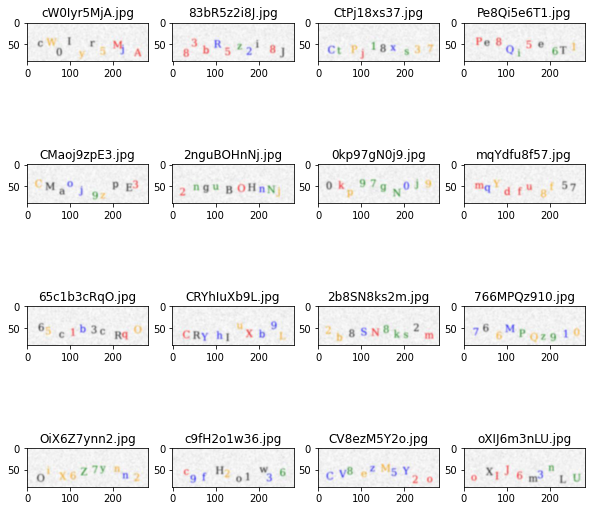

In [5]:
show_random_images(df,"paths")

In [6]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [7]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

In [8]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)

def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

In [9]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, lbl_enc

In [10]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

In [11]:
class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [12]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [14]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

In [15]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

In [16]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 4.9590409602407455, valid_loss: 4.249098914010184


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 1, train_loss: 4.238896477497704, valid_loss: 4.248136081392803


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 2, train_loss: 4.23881180036555, valid_loss: 4.247667282346695


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 3, train_loss: 4.238998849269128, valid_loss: 4.248284052288722


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 4, train_loss: 4.238187711996888, valid_loss: 4.249765577770415


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 5, train_loss: 4.236954351089776, valid_loss: 4.242224746280247


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 6, train_loss: 4.235225008393689, valid_loss: 4.241494859967913


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 7, train_loss: 4.230763023742351, valid_loss: 4.231081727951292


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 8, train_loss: 4.2197022886936875, valid_loss: 4.212718978760734


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '1--------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '1--------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '1--------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '1--------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '1--------------------------------------------------------------------------')]
Epoch: 9, train_loss: 4.206119945587104, valid_loss: 4.201122049301389


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '188888--------------------------------------------------------------------3'),
 ('y6V9drq2FD',
  '188-----------------------------------------------------------------------3'),
 ('VIQpVKs9cA',
  '1888----------------------------------------------------------------------3'),
 ('Vc0XVdk8Rl',
  '188-----------------------------------------------------------------------3'),
 ('Il40rp4HT2',
  '1888----------------------------------------------------------------------3')]
Epoch: 10, train_loss: 4.185302486216408, valid_loss: 4.176390042380681


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '9999969-------------------------------------------------------------------2'),
 ('y6V9drq2FD',
  '9999999-------------------------------------------------------------------3'),
 ('VIQpVKs9cA',
  '9999999-------------------------------------------------------------------2'),
 ('Vc0XVdk8Rl',
  '9999922-------------------------------------------------------------------2'),
 ('Il40rp4HT2',
  '9999999-------------------------------------------------------------------2')]
Epoch: 11, train_loss: 4.164712174959335, valid_loss: 4.160250731876919


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '4444410------------------------------------------------------------------70'),
 ('y6V9drq2FD',
  '2222222------------------------------------------------------------------10'),
 ('VIQpVKs9cA',
  '11111111-----------------------------------------------------------------10'),
 ('Vc0XVdk8Rl',
  '7250000------------------------------------------------------------------77'),
 ('Il40rp4HT2',
  '11111000-----------------------------------------------------------------77')]
Epoch: 12, train_loss: 4.148247570593446, valid_loss: 4.140737105929662


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '4444446------------------------------------------------------------------90'),
 ('y6V9drq2FD',
  '7558888------------------------------------------------------------------90'),
 ('VIQpVKs9cA',
  '44444444-----------------------------------------------------------------90'),
 ('Vc0XVdk8Rl',
  '4444888------------------------------------------------------------------17'),
 ('Il40rp4HT2',
  '44444444-----------------------------------------------------------------77')]
Epoch: 13, train_loss: 4.122136938000233, valid_loss: 4.104293577254764


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '44444664-----------------------------------------------------------------44'),
 ('y6V9drq2FD',
  '4949966------------------------------------------------------------------94'),
 ('VIQpVKs9cA',
  '44444444-----------------------------------------------------------------94'),
 ('Vc0XVdk8Rl',
  '44444444-----------------------------------------------------------------27'),
 ('Il40rp4HT2',
  '44444444-----------------------------------------------------------------77')]
Epoch: 14, train_loss: 4.086698609601117, valid_loss: 4.072548563518222


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '44411444-----------------------------------------------------------------11'),
 ('y6V9drq2FD',
  '4444666------------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '44444444-----------------------------------------------------------------96'),
 ('Vc0XVdk8Rl',
  '11114444-----------------------------------------------------------------27'),
 ('Il40rp4HT2',
  '44444444-----------------------------------------------------------------27')]
Epoch: 15, train_loss: 4.053621816804523, valid_loss: 4.040283664824471


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '65555886-----------------------------------------------------------------17'),
 ('y6V9drq2FD',
  '99996857-----------------------------------------------------------------00'),
 ('VIQpVKs9cA',
  '44444496-----------------------------------------------------------------06'),
 ('Vc0XVdk8Rl',
  '25994444-----------------------------------------------------------------17'),
 ('Il40rp4HT2',
  '25994444-----------------------------------------------------------------27')]
Epoch: 16, train_loss: 4.023004113463271, valid_loss: 4.006571614553058


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '68888994-----------------------------------------------------------------22'),
 ('y6V9drq2FD',
  '64466227-----------------------------------------------------------------09'),
 ('VIQpVKs9cA',
  '44444988-----------------------------------------------------------------09'),
 ('Vc0XVdk8Rl',
  '28994444-----------------------------------------------------------------12'),
 ('Il40rp4HT2',
  '28994444-----------------------------------------------------------------27')]
Epoch: 17, train_loss: 3.9904755169714323, valid_loss: 3.971647656153119


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '48331991-----------------------------------------------------------------21'),
 ('y6V9drq2FD',
  '84466237-----------------------------------------------------------------79'),
 ('VIQpVKs9cA',
  '64449998-----------------------------------------------------------------04'),
 ('Vc0XVdk8Rl',
  '80094444-----------------------------------------------------------------95'),
 ('Il40rp4HT2',
  '80994444-----------------------------------------------------------------27')]
Epoch: 18, train_loss: 3.953203512127404, valid_loss: 3.928913093748547


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '46330996-----------------------------------------------------------------21'),
 ('y6V9drq2FD',
  '39466237-----------------------------------------------------------------09'),
 ('VIQpVKs9cA',
  '64466663-----------------------------------------------------------------29'),
 ('Vc0XVdk8Rl',
  '80994446-----------------------------------------------------------------93'),
 ('Il40rp4HT2',
  '19944444-----------------------------------------------------------------07')]
Epoch: 19, train_loss: 3.9137851696454824, valid_loss: 3.8831972546047635


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '46111999-----------------------------------------------------------------00'),
 ('y6V9drq2FD',
  '39996887-----------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '60099988-----------------------------------------------------------------24'),
 ('Vc0XVdk8Rl',
  '83194449-----------------------------------------------------------------95'),
 ('Il40rp4HT2',
  '80944444-----------------------------------------------------------------35')]
Epoch: 20, train_loss: 3.8701589624157595, valid_loss: 3.8384917350042436


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '461--996-----------------------------------------------------------------11'),
 ('y6V9drq2FD',
  '86666687-----------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '41694667-----------------------------------------------------------------74'),
 ('Vc0XVdk8Rl',
  '87144444-----------------------------------------------------------------65'),
 ('Il40rp4HT2',
  '16444444-----------------------------------------------------------------37')]
Epoch: 21, train_loss: 3.827956123843286, valid_loss: 3.79424854687282


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '466---96-----------------------------------------------------------------01'),
 ('y6V9drq2FD',
  '36666827-----------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '63094461-----------------------------------------------------------------74'),
 ('Vc0XVdk8Rl',
  '67144444-----------------------------------------------------------------93'),
 ('Il40rp4HT2',
  '80944444-----------------------------------------------------------------17')]
Epoch: 22, train_loss: 3.7841916465420495, valid_loss: 3.7453817677876304


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '96-----6-----------------------------------------------------------------81'),
 ('y6V9drq2FD',
  '06996--3-----------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '93-444-6-----------------------------------------------------------------74'),
 ('Vc0XVdk8Rl',
  '67-44444-----------------------------------------------------------------93'),
 ('Il40rp4HT2',
  '8--44444-----------------------------------------------------------------17')]
Epoch: 23, train_loss: 3.7396612006436443, valid_loss: 3.691314863780188


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '96-----6-----------------------------------------------------------------01'),
 ('y6V9drq2FD',
  '06-----6-----------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '95--44-6-----------------------------------------------------------------74'),
 ('Vc0XVdk8Rl',
  '67-----6-----------------------------------------------------------------93'),
 ('Il40rp4HT2',
  '8--44--4-----------------------------------------------------------------37')]
Epoch: 24, train_loss: 3.6857650335051027, valid_loss: 3.6356340892731196


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '9------0-----------------------------------------------------9-----------01'),
 ('y6V9drq2FD',
  '3------6-----------------------------------------------------------------06'),
 ('VIQpVKs9cA',
  '93-----4-----------------------------------------------------------------74'),
 ('Vc0XVdk8Rl',
  '97-----------------------------------------------------------------------93'),
 ('Il40rp4HT2',
  '3------4-----------------------------------------------------------------17')]
Epoch: 25, train_loss: 3.6214212354927673, valid_loss: 3.552126820125277


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '9-------------------9------6------6-----5--------1----8-----9------------61'),
 ('y6V9drq2FD',
  '2---------------------0----9------9-------9---3-------9------5-----------06'),
 ('VIQpVKs9cA',
  '6--------------------------8-------------0-----4------5-------9----------24'),
 ('Vc0XVdk8Rl',
  '6-------------------3--------8----4------0------9------4----1------------93'),
 ('Il40rp4HT2',
  '0--------------------u------4------6------3-----9-----4------9-----------13')]
Epoch: 26, train_loss: 3.347366494353245, valid_loss: 2.938791142569648


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '9-------------------9------6------8-----3--------1----9-----9------------61'),
 ('y6V9drq2FD',
  '2---------------------0----9------9-------9---r-------9------7-----------08'),
 ('VIQpVKs9cA',
  '9--------------------------8-------9------6----4------7-------9----------24'),
 ('Vc0XVdk8Rl',
  '9-------------------c--------6----4------0------9------9----0------------91'),
 ('Il40rp4HT2',
  '1--------------------1------4------6------l-----9-----4------9-----------13')]
Epoch: 27, train_loss: 2.9170964302008784, valid_loss: 2.746410778590611


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '9-------------------8-------6-----8-----3--------1----8-----9------------01'),
 ('y6V9drq2FD',
  '3---------------------1----8------9-------9---a-------9------7-----------08'),
 ('VIQpVKs9cA',
  '9---------------------l----8-------8------6-----4-----7-------9----------14'),
 ('Vc0XVdk8Rl',
  '9-------------------c--------0----4------0------9------9----0------------91'),
 ('Il40rp4HT2',
  '1--------------------o------4------0------c-----9-----4------9-----------13')]
Epoch: 28, train_loss: 2.7701220673312092, valid_loss: 2.651656396805294


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '9-------------------8------8------8-----j--------1----8-----9------------80'),
 ('y6V9drq2FD',
  'v---------------------0----8------9-------9-----------9------7-----------08'),
 ('VIQpVKs9cA',
  '9---------------------o----9-------9------8----4------7-------9----------14'),
 ('Vc0XVdk8Rl',
  '9-------------------c--------8----4------6------9------9----8------------91'),
 ('Il40rp4HT2',
  '1--------------------1------4------0------v-----9-----4------9-----------13')]
Epoch: 29, train_loss: 2.6592694201223805, valid_loss: 2.5482291569785467


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '8-------------------8------6------8-----3--------1----8-----9------------80'),
 ('y6V9drq2FD',
  'S---------------------6----8------9-------9---r-------9------7-----------06'),
 ('VIQpVKs9cA',
  '9--------------------C-----0-------8------8-----4-----7------------------74'),
 ('Vc0XVdk8Rl',
  '8-------------------i-------0-----M------6-----9------------8------------91'),
 ('Il40rp4HT2',
  '1--------------------u------4------0------r-----k-----4------N-----------13')]
Epoch: 30, train_loss: 2.5511453363442294, valid_loss: 2.3885092886667403


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '8-------------------8------8------8-----3--------1----8-----9------------80'),
 ('y6V9drq2FD',
  'S---------------------6----8------9-------9---r-------9------7-----------08'),
 ('VIQpVKs9cA',
  '9---------------------o----8-------8------E-----4-----5------------------24'),
 ('Vc0XVdk8Rl',
  '8-------------------i-------0-----M------E------9------k----8------------91'),
 ('Il40rp4HT2',
  '1--------------------y------4------0------3-----V-----4------N-----------13')]
Epoch: 31, train_loss: 2.387708455588847, valid_loss: 2.203728202789549


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '8-------------------8------8------D-----3--------1----8-----9------------80'),
 ('y6V9drq2FD',
  '1--------------------6-----k------9-------9---t-------9------7-----------68'),
 ('VIQpVKs9cA',
  '9--------------------------Q-------8-----------4------3------9-----------c4'),
 ('Vc0XVdk8Rl',
  '9-------------------j-------8----M-------E-----9------4-----8------------91'),
 ('Il40rp4HT2',
  '1--------------------y------4------0------r----P------4------N-----------13')]
Epoch: 32, train_loss: 2.2160262549114056, valid_loss: 2.0336743158007424


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '6------------------6-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'o--------------------6----V------9--------9---r-------9------7-----------68'),
 ('VIQpVKs9cA',
  '9--------------------t-----Q-------8-----V-----K------3------9-----------c4'),
 ('Vc0XVdk8Rl',
  '8-------------------i-------8----A-------------9------Z-----8------------91'),
 ('Il40rp4HT2',
  '1--------------------y-----4-------0------i----P------4------N-----------13')]
Epoch: 33, train_loss: 2.06579576123036, valid_loss: 1.8712709971836634


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  '6------------------b-------8-----D------3--------1----p-----B------------80'),
 ('y6V9drq2FD',
  '1--------------------6----k------9--------d---r-------B------7-----------68'),
 ('VIQpVKs9cA',
  '9--------------------1-----Q-------8-----V-----K------3------9-----------c4'),
 ('Vc0XVdk8Rl',
  'k-------------------i-------8----A------V------9------K----8-------------H1'),
 ('Il40rp4HT2',
  '1--------------------y-----4-------0------r----p------4-----H------------x7')]
Epoch: 34, train_loss: 1.9251432054631452, valid_loss: 1.7241625634450761


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------6-------8-----D------3-------1-----P-----B------------80'),
 ('y6V9drq2FD',
  '1--------------------6----k------9-------d----r------B-------7-----------68'),
 ('VIQpVKs9cA',
  'k--------------------1-----Q-------p-----V----K-------3------9-----------cX'),
 ('Vc0XVdk8Rl',
  'k-------------------j-------0----A------V------9------k----8-------------H1'),
 ('Il40rp4HT2',
  '1--------------------t-----4-------0-----j-----p------4-----H------------17')]
Epoch: 35, train_loss: 1.7686668477727507, valid_loss: 1.5264758231147888


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------6-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  '1--------------------6----V------9--------d---r-------q------7-----------68'),
 ('VIQpVKs9cA',
  'k--------------------C-----Q-------p-----V----K-------3------9-----------cA'),
 ('Vc0XVdk8Rl',
  'k-------------------j-------0----A------E------d------k----8-------------H1'),
 ('Il40rp4HT2',
  '1--------------------t-----4-------0------r----p------4------H-----------17')]
Epoch: 36, train_loss: 1.616114731792023, valid_loss: 1.387384543343196


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------b-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  '1--------------------6----V------9--------d---r-------q------2-----------68'),
 ('VIQpVKs9cA',
  'V--------------------1-----Q-------p-----V----K-------3------9-----------cA'),
 ('Vc0XVdk8Rl',
  'k-------------------j-------0----A------V------w------k----8-------------W1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0------r----p------4-----H------------17')]
Epoch: 37, train_loss: 1.4840571575435821, valid_loss: 1.2577520116927132


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q------2-----------68'),
 ('VIQpVKs9cA',
  'k--------------------I-----Q-------p-----V----K-------3------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----A------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------t-----4-------0------r----p------4-----H------------17')]
Epoch: 38, train_loss: 1.3769204301054905, valid_loss: 1.1537928448783026


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----l-------q------2-----------68'),
 ('VIQpVKs9cA',
  'k--------------------1-----Q-------p-----V----K-------i------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----A------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------i-----p------4-----H------------T7')]
Epoch: 39, train_loss: 1.270534611510553, valid_loss: 1.0545594171872215


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q------2-----------6D'),
 ('VIQpVKs9cA',
  'k--------------------1-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----A------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0------r----p------4-----HH-----------T2')]
Epoch: 40, train_loss: 1.1688382294207653, valid_loss: 0.9506133331192864


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------b-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---j-------q------2-----------6D'),
 ('VIQpVKs9cA',
  'k--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----A------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0-----i-----p------4-----H------------T2')]
Epoch: 41, train_loss: 1.083723609972593, valid_loss: 0.8644953266022697


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------z-------1-----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q------2-----------6D'),
 ('VIQpVKs9cA',
  '4--------------------1-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------i-----p------4-----H------------T7')]
Epoch: 42, train_loss: 1.002942926612671, valid_loss: 0.8316903663060021


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8n'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------qq------2-----------YD'),
 ('VIQpVKs9cA',
  'V--------------------l-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------i-----p------4-----H------------12')]
Epoch: 43, train_loss: 0.9268093854453593, valid_loss: 0.7672657578710526


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------T----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------l-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----A------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0------i----p------4-----H------------T2')]
Epoch: 44, train_loss: 0.8669913349736013, valid_loss: 0.6987778317360651


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V-------9-------d---j-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0------r----p------4-----H------------T2')]
Epoch: 45, train_loss: 0.8070501222491899, valid_loss: 0.617924187864576


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---t-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------1-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0-----i-----p------4-----H------------T2')]
Epoch: 46, train_loss: 0.7533848639279869, valid_loss: 0.5962182160407777


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------8n'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0-----r-----p------4-----H------------12')]
Epoch: 47, train_loss: 0.7064156944120756, valid_loss: 0.580314522697812


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------V-------8-----D------3--------1----P-----B------------8n'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0-----i-----p------4-----H------------J2')]
Epoch: 48, train_loss: 0.6676979514887659, valid_loss: 0.5034959699426379


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------99-------d---r-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------R1'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0-----rr----p------4-----H------------T2')]
Epoch: 49, train_loss: 0.6227920021511099, valid_loss: 0.466397631262976


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3--------1----P-----B------------8u'),
 ('y6V9drq2FD',
  'y--------------------6----V-------9-------d---r-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4-------0------r----p------4-----H------------T2')]
Epoch: 50, train_loss: 0.5903992912803195, valid_loss: 0.4407026630545419


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 51, train_loss: 0.5565650085678744, valid_loss: 0.40845777259932625


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8u'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 52, train_loss: 0.5265526648207202, valid_loss: 0.37337426533774726


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8u'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 53, train_loss: 0.5005522835106452, valid_loss: 0.361179356537168


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8u'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------jA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  '1--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 54, train_loss: 0.47473021669455573, valid_loss: 0.3418693433678339


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'E------------------P-------8-----D------3-------1-----P-----B------------8u'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r------qq-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------Y------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 55, train_loss: 0.45038718800349936, valid_loss: 0.340214389420691


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------V-------8-----D------3-------1-----P-----B------------8u'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 56, train_loss: 0.4289133807588005, valid_loss: 0.3090683366098101


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------V-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 57, train_loss: 0.40420860438533196, valid_loss: 0.2794123727177817


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'E------------------P-------8-----D------3-------1-----P-----B------------80'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q------2-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 58, train_loss: 0.3898496305434361, valid_loss: 0.265008324668521


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 59, train_loss: 0.37589904163065857, valid_loss: 0.2473739231862719


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'E------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------dd---r------qq-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 60, train_loss: 0.34729631914762155, valid_loss: 0.229963356776843


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'J--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 61, train_loss: 0.34156479460202144, valid_loss: 0.22534908921945662


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'E------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 62, train_loss: 0.3200873717215726, valid_loss: 0.22852387101877303


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------iA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4-------0-----r-----p------4-----H------------T2')]
Epoch: 63, train_loss: 0.30213628402294107, valid_loss: 0.19468595773454697


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----D-------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 64, train_loss: 0.29632010759511174, valid_loss: 0.19744286792618887


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------qq-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 65, train_loss: 0.2854506351702167, valid_loss: 0.21279839237057974


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------qq-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 66, train_loss: 0.271403861008783, valid_loss: 0.16883471158761826


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9--------d---r------qq-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------00-----r-----p------4-----H------------T2')]
Epoch: 67, train_loss: 0.2620968776581342, valid_loss: 0.1582519824779223


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----DD------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V---K--------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'J--------------------l-----4------0------r-----p-----44-----H------------T2')]
Epoch: 68, train_loss: 0.25050491433372296, valid_loss: 0.15401307647190396


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'v--------------------6----V------9--------d---r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4-------0-----r-----p------4-----H------------T2')]
Epoch: 69, train_loss: 0.2354673153024372, valid_loss: 0.1392592489719391


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'v--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 70, train_loss: 0.2310743727597208, valid_loss: 0.14047155765787003


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'v--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 71, train_loss: 0.21442782680370032, valid_loss: 0.1301790258241078


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'v--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 72, train_loss: 0.20954144253771004, valid_loss: 0.128743367299201


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 73, train_loss: 0.2017587777061742, valid_loss: 0.13991753863436834


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8-----D------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'v--------------------6----V------9-------d----r-------q-----22-----------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'Y-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 74, train_loss: 0.19181842170324884, valid_loss: 0.12785275570220417
Patience at 5


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----DD------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'v--------------------6----X------9-------d----r------qq-----22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 75, train_loss: 0.18980543979743023, valid_loss: 0.10682764217730552
Patience at 4


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----D-------3-------1-----P-----B------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------22-----------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V----K-------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p------4-----H------------T2')]
Epoch: 76, train_loss: 0.18313887171434043, valid_loss: 0.11060720522488866
Patience at 3


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----D-------3-------1----P-----B-------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------2------------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V---K--------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p-----4------H------------T2')]
Epoch: 77, train_loss: 0.1752032735657946, valid_loss: 0.09881129517914757
Patience at 2


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----D-------3-------1-----P----B-------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------2------------FD'),
 ('VIQpVKs9cA',
  'Y--------------------I-----Q-------p-----V---K--------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0---W-------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p-----4------H------------T2')]
Epoch: 78, train_loss: 0.16798498329324366, valid_loss: 0.13978686775006946
Patience at 1


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----D-------3-------1-----P----B-------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------2------------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V---K--------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0----X------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p-----4------H------------T2')]
Epoch: 79, train_loss: 0.16500560198224035, valid_loss: 0.09173518040823558
Patience at 0


  0%|          | 0/563 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
/opt/conda/lib/python

[('FP8D31PB8O',
  'F------------------P-------8----D-------3-------1-----P----B-------------8O'),
 ('y6V9drq2FD',
  'y--------------------6----V------9-------d----r------q------2------------FD'),
 ('VIQpVKs9cA',
  'V--------------------I-----Q-------p-----V---K--------s------9-----------cA'),
 ('Vc0XVdk8Rl',
  'V-------------------c-------0---XX------V------d------k----8-------------Rl'),
 ('Il40rp4HT2',
  'I--------------------l-----4------0------r-----p-----4------H------------T2')]
Epoch: 80, train_loss: 0.1545484132178088, valid_loss: 0.09410717840942126
Early Stopping Implemented.


<AxesSubplot:title={'center':'Loss During Epoch Training'}, xlabel='Epoch No.', ylabel='Loss Value'>

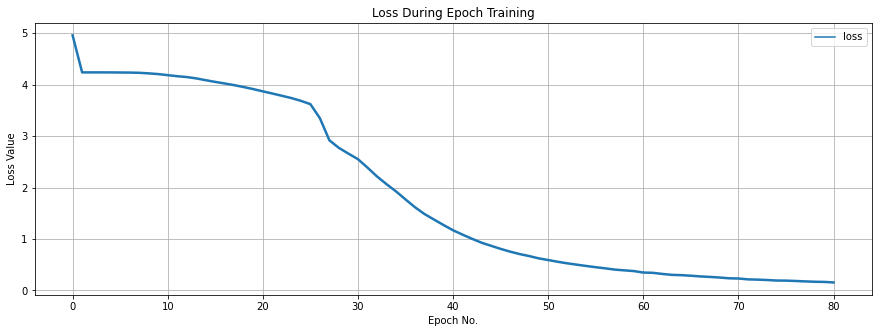

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

In [18]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
    )
    
    return img, eval_loader


def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

        return fin_preds

In [19]:
image_path, eval_loader = get_sample_photo()
print(image_path)

def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

['../input/captcha-images/RTaRhxJy06.jpg']


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


{'success': True, 'prediction': 'RTaRhxJy06', 'real': 'RTaRhxJy06'}

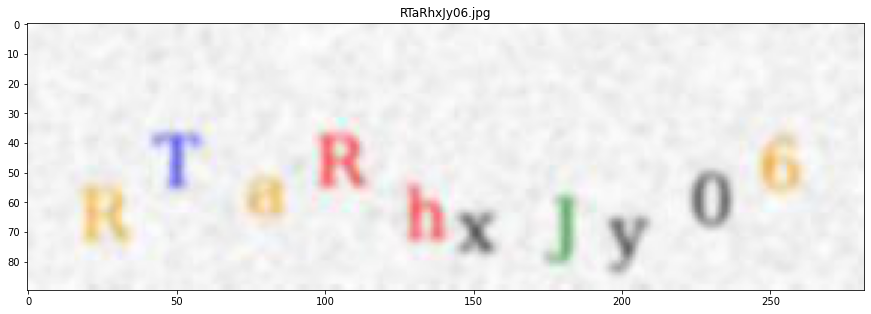

In [20]:
preds = predict_captcha(model, eval_loader, image_path)
preds